In [1]:
import numpy as np
import networkx as nx
from dwdynamics import ComplexDynamicsProblem, Objective,helpers ,instance# Difference a. We are using ComplexDynamicsProblem
import matplotlib.pyplot as plt
import json
import os
from dwave_networkx.generators.pegasus import (get_tuple_defragmentation_fn, fragmented_edges,
    pegasus_coordinates, pegasus_graph)
from dwave.system import DWaveSampler, EmbeddingComposite
import matplotlib.pyplot as plt
from collections import defaultdict
import re
from tqdm import tqdm
import scipy 
import pickle as pckl

In [96]:
import matplotlib.font_manager as fm
fm.fontManager.addfont("../times.ttf")  #path to the times.ttf file on your computer
plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ['Times New Roman'],
})
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
import sys
print(sys.path[1])

/usr/lib/python311.zip


In [3]:
import os
import re
import pandas as pd
import numpy as np
import math
import dimod.sampleset


# List instances

In [4]:
path = f'../data/instances/'
for item in os.listdir(path):
    if item[-5:] == '.pckl':    
        with open(os.path.join(path, item),'rb') as f:
            print(f"---------- System {item} ------------")
            data = pckl.load(f)
            print(data['H'])


---------- System 10.pckl ------------
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.57079633]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.  

# Analyze

In [5]:
def load_data(raw = False,topology='6.4',system=1):
    path = f'../data/results/hessian/{system}/'

    dfs = []
    for topology in [topology]:
        path += topology
        for file in os.listdir(path):
            precision = int(re.findall('(?<=precision_)\d+',file)[0])
            timepoints = int(re.findall('(?<=timepoints_)\d+',file)[0])
            with open(os.path.join(path,file),'r') as f:
                s = dimod.SampleSet.from_serializable(json.load(f))
        
            qpu_access_time = s.info['timing']['qpu_access_time']
            s = s.to_pandas_dataframe()
            if not raw:
                s = s[['energy','num_occurrences']]
            s['systemid'] = topology
            s['precision'] = precision
            s['timepoints'] = timepoints
            s['energy'] = abs(round(s['energy'],10))
            s['access_time'] = (qpu_access_time / s['num_occurrences'].sum()) * s['num_occurrences'] * 1e-3
            dfs.append(s)

    dfs_all = pd.concat(dfs)

    return dfs_all

def get_precision_timepoints_pairs(dfs):
    dfs = dfs.groupby(['precision','timepoints'])['num_occurrences'].count()
    return list(set(dfs.index))

In [6]:
topology='6.4'
dfs_all = load_data(topology=topology,system=4)
dfs_all_rounded = dfs_all.copy()
dfs_all_rounded['energy'] = dfs_all_rounded['energy'].apply(lambda x: math.ceil(x)) # for displaying in a histogram


In [7]:
dfs_grouped =dfs_all.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum() 
dfs_grouped_rounded = dfs_all_rounded.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum()
dfs_keys = set([(key[0],key[1],key[2]) for key in dfs_grouped.keys()])
for key in dfs_keys:
    dfs_grouped[key] = dfs_grouped[key] / dfs_grouped[key].sum() * 100
    dfs_grouped_rounded[key] = dfs_grouped_rounded[key] / dfs_grouped_rounded[key].sum() * 100

dfs_grouped_rounded 

/tmp/ipykernel_42368/4200412015.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.3120e+00 1.9584e+01 2.6816e+01 2.3088e+01 1.4080e+01 5.8360e+00
 2.4280e+00 6.2800e-01 1.4000e-01 4.0000e-02 3.2000e-02 8.0000e-03
 8.0000e-03]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs_grouped[key] = dfs_grouped[key] / dfs_grouped[key].sum() * 100
/tmp/ipykernel_42368/4200412015.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.3120e+00 4.6400e+01 3.7168e+01 8.2640e+00 7.6800e-01 7.2000e-02
 1.6000e-02]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs_grouped_rounded[key] = dfs_grouped_rounded[key] / dfs_grouped_rounded[key].sum() * 100


systemid  precision  timepoints  energy
6.4       2          2           0          7.312
                                 1         46.400
                                 2         37.168
                                 3          8.264
                                 4          0.768
                                 5          0.072
                                 6          0.016
                     3           0          1.380
                                 1         21.012
                                 2         41.580
                                 3         27.152
                                 4          7.564
                                 5          1.156
                                 6          0.132
                                 7          0.024
                     4           0          0.312
                                 1          9.156
                                 2         30.600
                                 3         34.980
          

# Interpret results

[(2, 5)]
(4, 4)


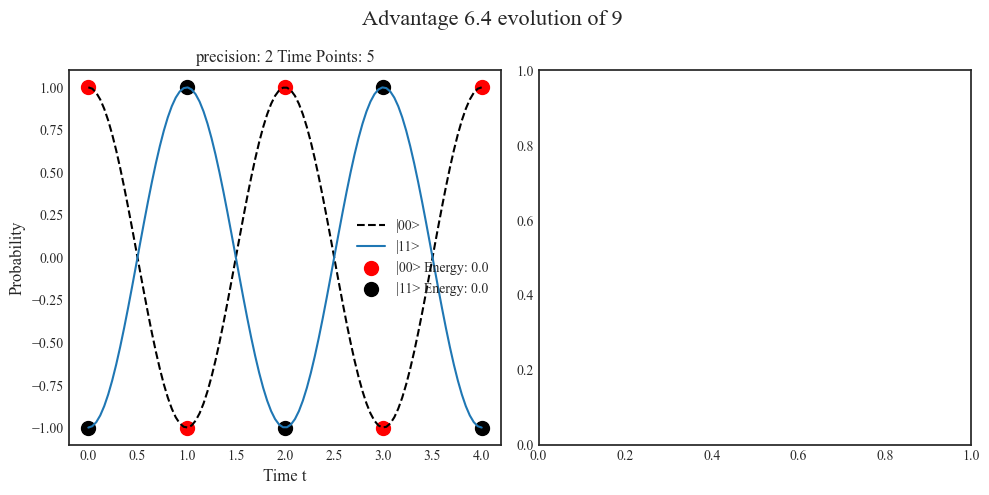

In [78]:
import qutip as qp

system = 9

dfs_data_raw = load_data(raw=True,system=system)
tp_pairs = get_precision_timepoints_pairs(dfs_data_raw)
tp_pairs.sort(key=lambda x: x[0]*10 + x[1])
tp_pairs = [(2,5)]
print(tp_pairs)
dfs_data_raw['systemid']
# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.


# Create a single axis for the plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)
axes = axes.flatten()

system_latex_dict = {
    1: 'H = $\frac{\pi}{2}\sigma_y$',
    3: 'one qubit pt symmetric system (seed=1)',
    4: 'maximally entangled 2 qubit system'
}




for i, (precision,timepoints) in enumerate(tp_pairs):
    inst = instance.Instance(system)
    inst.create_instance(precision, timepoints)
    H = inst.H
    PSI0 = inst.psi0
    dim = int(math.log2(H.shape[0]))    #dim=2

    print(H.shape)
    #H = instance['H']

    #baseline 
    # Projectors on |0..0⟩ and |1..1⟩
    P_00 = qp.tensor([qp.basis(2, 0)]*dim).proj()
    P_11 = qp.tensor([qp.basis(2, 1)]*dim).proj()

    P_00 = qp.tensor([qp.sigmaz()]+ [qp.qeye(2)]*(dim-1))
    P_11 = qp.tensor([qp.qeye(2)]*(dim-1) + [qp.sigmaz()])

    H_qp = qp.Qobj(H,dims=[[2]*dim,[2]*dim])

    psi_0 = qp.basis(2**dim, 1)
    psi_0.dims = [[2]*dim, [1]]  # Naprawa błędu wymiarów

    #psi_0 = qp.tensor(qp.basis(2, 0), qp.basis(2, 1))
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[P_00,P_11]).expect
    ax = axes[i]

    ax.plot(times, baseline[0], "k--",label="|00>")
    ax.plot(times, baseline[1],label="|11>")


    problem = inst.problem
    dfs_filtered = dfs_data_raw[(dfs_data_raw.precision == precision) & (dfs_data_raw.timepoints == timepoints)]
    dfs_filtered = dfs_filtered.drop(['num_occurrences'],axis=1)
    dfs_filtered.drop_duplicates(inplace=True)
    dfs_filtered = dfs_filtered.sort_values(by='energy').head(1)
    dfs_filtered = dfs_filtered.sort_values(by='energy',ascending=False)
    energies = list(dfs_filtered['energy'])
    dfs_filtered = dfs_filtered.filter(regex='\d+')
    dfs_filtered = dfs_filtered.apply(pd.to_numeric)
    for j, (_, row) in enumerate(dfs_filtered.iterrows()): 
        sol_dict = row.dropna().to_dict()
        sol_dict = {key:int(value) for key,value in sol_dict.items()}

        vec =problem.interpret_sample(sol_dict)

        expect_00 = [(state.conj() @ P_00.full() @ state).real for state in vec]
        expect_11 = [(state.conj() @ P_11.full() @ state).real for state in vec]

        ax.scatter(problem.times, expect_00, color=colors[j % len(colors)], marker=markers[j % len(markers)], label=f"|00> Energy: {round(energies[j],4)}", alpha=1.0, s=100)
        ax.scatter(problem.times, expect_11, color='black', marker=markers[j % len(markers)],label=f"|11> Energy: {round(energies[j],4)}", alpha=1.0, s=100)

        #ax.plot(problem.times, expect, color=colors[j % len(colors)], alpha=0.5, linewidth=0.1)
    ax.set_xlabel("Time t", fontsize=12)
    ax.set_ylabel(r"Probability", fontsize=12)
    ax.set_title(f"precision: {problem.num_bits_per_var} Time Points: {len(problem.times)}")


    ax.legend()
fig.suptitle(f"Advantage {topology} " +rf"evolution of {system} ",fontsize=16)
plt.tight_layout()
#plt.savefig(f'../plots/system{topology}_dynamic_{system}.pdf')
plt.show()



[(2, 5)]
(2, 2)


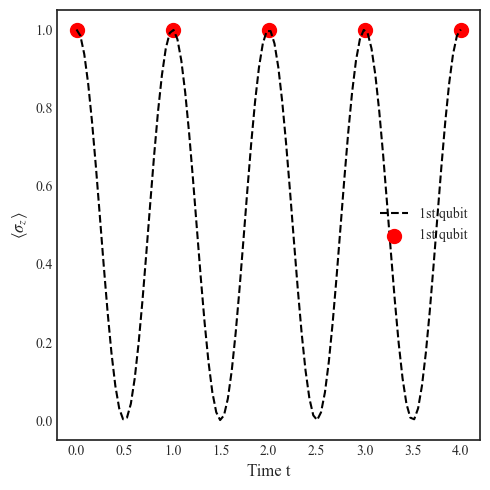

In [97]:
import qutip as qp




system = 2

dfs_data_raw = load_data(raw=True,system=system)
tp_pairs = get_precision_timepoints_pairs(dfs_data_raw)
tp_pairs.sort(key=lambda x: x[0]*10 + x[1])
tp_pairs = [(2,5)]
print(tp_pairs)
dfs_data_raw['systemid']
# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.


# Create a single axis for the plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=False)


system_latex_dict = {
    1: 'H = $\frac{\pi}{2}\sigma_y$',
    3: 'one qubit pt symmetric system (seed=1)',
    4: 'maximally entangled 2 qubit system'
}




for i, (precision,timepoints) in enumerate(tp_pairs):
    inst = instance.Instance(system)
    inst.create_instance(precision, timepoints)
    H = inst.H
    PSI0 = inst.psi0
    dim = int(math.log2(H.shape[0]))    #dim=2

    print(H.shape)
    #H = instance['H']

    #baseline 
    # Projectors on |0..0⟩ and |1..1⟩
    P_00 = qp.tensor([qp.basis(2, 0)]*dim).proj()
    P_11 = qp.tensor([qp.basis(2, 1)]*dim).proj()

    P_00 = qp.tensor([qp.sigmaz()]+ [qp.qeye(2)]*(dim-1))
    P_11 = qp.tensor([qp.qeye(2)]*(dim-1) + [qp.sigmaz()])

    H_qp = qp.Qobj(H,dims=[[2]*dim,[2]*dim])

    psi_0 = qp.Qobj(PSI0)
    psi_0.dims = [[2]*dim, [1]]  # Naprawa błędu wymiarów

    #psi_0 = qp.tensor(qp.basis(2, 0), qp.basis(2, 1))
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[P_00,P_11]).expect
    

    ax.plot(times, baseline[0], "k--",label="1st qubit")
    #ax.plot(times, baseline[1],label="2nd qubit")


    problem = inst.problem
    dfs_filtered = dfs_data_raw[(dfs_data_raw.precision == precision) & (dfs_data_raw.timepoints == timepoints)]
    dfs_filtered = dfs_filtered.drop(['num_occurrences'],axis=1)
    dfs_filtered.drop_duplicates(inplace=True)
    dfs_filtered = dfs_filtered.sort_values(by='energy').head(1)
    dfs_filtered = dfs_filtered.sort_values(by='energy',ascending=False)
    energies = list(dfs_filtered['energy'])
    dfs_filtered = dfs_filtered.filter(regex='\d+')
    dfs_filtered = dfs_filtered.apply(pd.to_numeric)
    for j, (_, row) in enumerate(dfs_filtered.iterrows()): 
        sol_dict = row.dropna().to_dict()
        sol_dict = {key:int(value) for key,value in sol_dict.items()}

        vec =problem.interpret_sample(sol_dict)

        expect_00 = [(state.conj() @ P_00.full() @ state).real for state in vec]
        expect_11 = [(state.conj() @ P_11.full() @ state).real for state in vec]

        ax.scatter(problem.times, expect_00, color=colors[j % len(colors)], marker=markers[j % len(markers)], label=f"1st qubit", alpha=1.0, s=100)
        #ax.scatter(problem.times, expect_11, color='black', marker=markers[j % len(markers)],label=f"2nd qubit", alpha=1.0, s=100)

    ax.set_xlabel("Time t", fontsize=12)
    ax.set_ylabel(r"$\langle \sigma_z \rangle$", fontsize=12)


    ax.legend()
plt.tight_layout()
plt.savefig(f'../plots/system{topology}_dynamic_{system}.pdf')
plt.show()



(4, 4)
(4, 4)
(4, 4)
(4, 4)


IndexError: index 3 is out of bounds for axis 0 with size 3

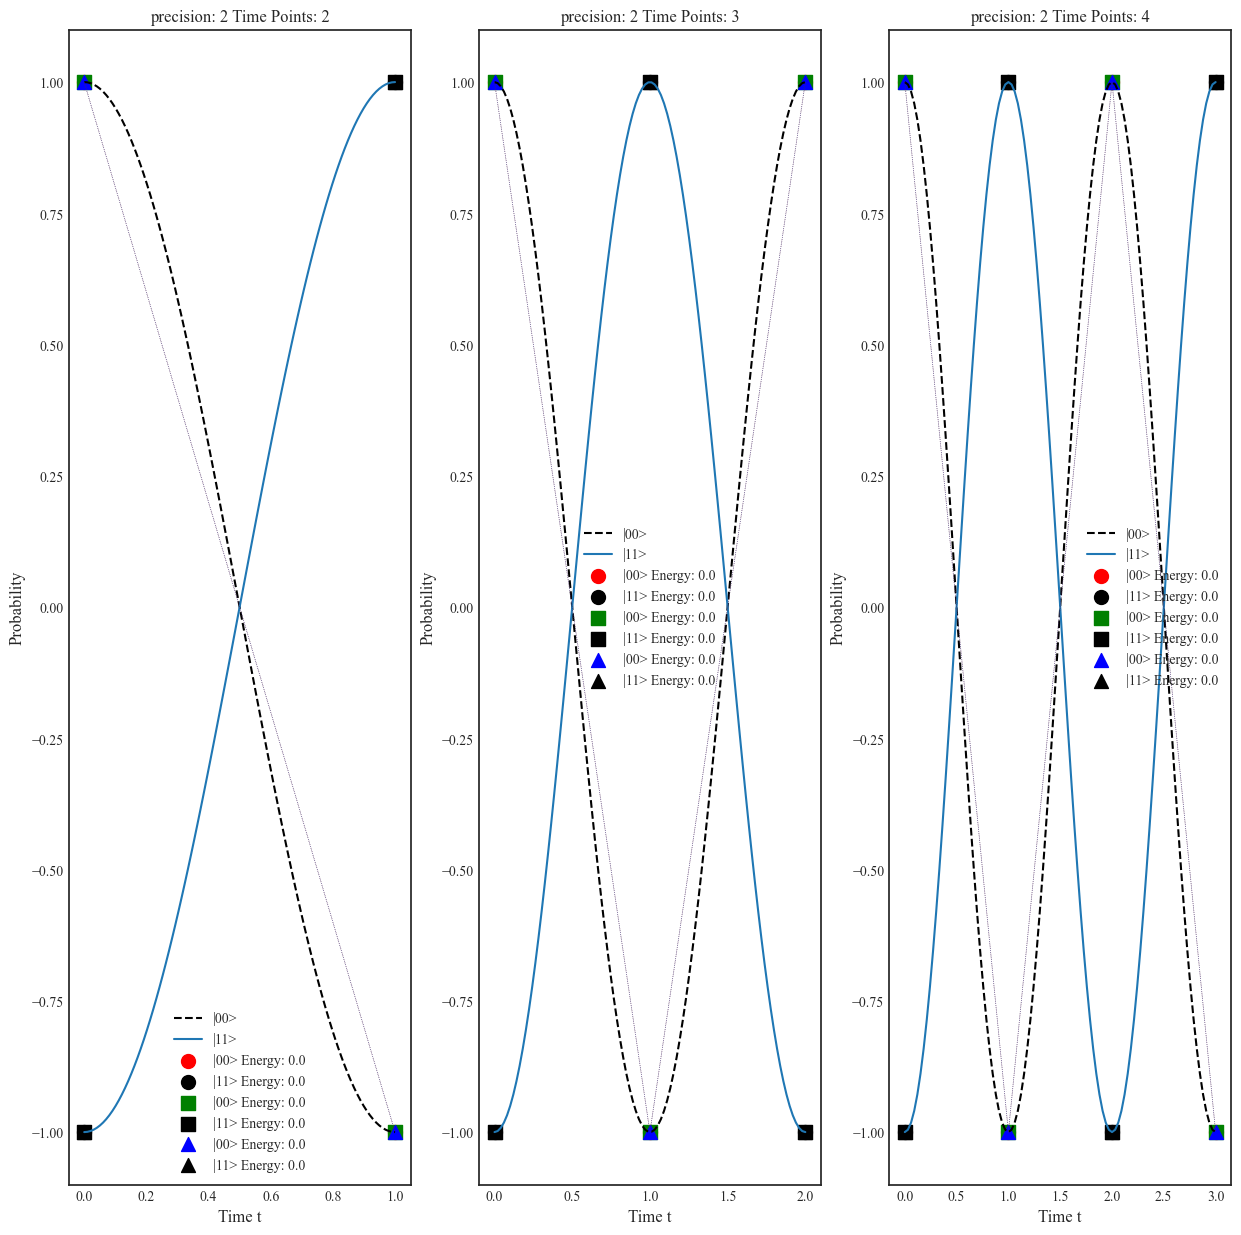

In [ ]:
import qutip as qp

system = 9

dfs_data_raw = load_data(raw=True,system=system)
tp_pairs = get_precision_timepoints_pairs(dfs_data_raw)
tp_pairs.sort(key=lambda x: x[0]*10 + x[1])
dfs_data_raw['systemid']
# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.


# Create a single axis for the plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
axes = axes.flatten()

system_latex_dict = {
    1: 'H = $\frac{\pi}{2}\sigma_y$',
    3: 'one qubit pt symmetric system (seed=1)',
    4: 'maximally entangled 2 qubit system'
}




for i, (precision,timepoints) in enumerate(tp_pairs):
    inst = instance.Instance(system)
    inst.create_instance(precision, timepoints)
    H = inst.H
    PSI0 = inst.psi0
    dim = int(math.log2(H.shape[0]))    #dim=2

    print(H.shape)
    #H = instance['H']

    #baseline 
    # Projectors on |0..0⟩ and |1..1⟩
    #P_00 = qp.tensor([qp.basis(2, 0)]*dim).proj()
    #P_11 = qp.tensor([qp.basis(2, 1)]*dim).proj()

    P_00 = qp.tensor([qp.sigmaz()]+ [qp.qeye(2)]*(dim-1))
    P_11 = qp.tensor([qp.qeye(2)]*(dim-1) + [qp.sigmaz()])

    H_qp = qp.Qobj(H,dims=[[2]*dim,[2]*dim])

    psi_0 = qp.Qobj(PSI0)
    psi_0.dims = [[2]*dim, [1]]  # Naprawa błędu wymiarów

    #psi_0 = qp.tensor(qp.basis(2, 0), qp.basis(2, 1))
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[P_00,P_11]).expect
    ax = axes[i]

    ax.plot(times, baseline[0], "k--",label="|00>")
    ax.plot(times, baseline[1],label="|11>")


    problem = inst.problem
    dfs_filtered = dfs_data_raw[(dfs_data_raw.precision == precision) & (dfs_data_raw.timepoints == timepoints)]
    dfs_filtered = dfs_filtered.drop(['num_occurrences'],axis=1)
    dfs_filtered.drop_duplicates(inplace=True)
    dfs_filtered = dfs_filtered.sort_values(by='energy').head(3)
    dfs_filtered = dfs_filtered.sort_values(by='energy',ascending=False)
    energies = list(dfs_filtered['energy'])
    dfs_filtered = dfs_filtered.filter(regex='\d+')
    dfs_filtered = dfs_filtered.apply(pd.to_numeric)
    for j, (_, row) in enumerate(dfs_filtered.iterrows()): 
        sol_dict = row.dropna().to_dict()
        sol_dict = {key:value for key,value in sol_dict.items()}

        vec =problem.interpret_sample(sol_dict)

        expect_00 = [(state.conj() @ P_00.full() @ state).real for state in vec]
        expect_11 = [(state.conj() @ P_11.full() @ state).real for state in vec]

        ax.scatter(problem.times, expect_00, color=colors[j % len(colors)], marker=markers[j % len(markers)], label=f"|00> Energy: {round(energies[j],4)}", alpha=1.0, s=100)
        ax.scatter(problem.times, expect_11, color='black', marker=markers[j % len(markers)],label=f"|11> Energy: {round(energies[j],4)}", alpha=1.0, s=100)
        ax.plot(problem.times, expect_00, alpha=0.5, color=colors[j % len(colors)], linestyle=':', linewidth=0.5)
    ax.set_xlabel("Time t", fontsize=12)
    ax.set_ylabel(r"Probability", fontsize=12)
    ax.set_title(f"precision: {problem.num_bits_per_var} Time Points: {len(problem.times)}")


    ax.legend()
#fig.suptitle(f"Advantage {topology} " +rf"evolution of {system} ",fontsize=16)
plt.tight_layout()
#plt.savefig(f'../plots/system{topology}_dynamic_{system}.pdf')
plt.show()



In [10]:
helpers.return_tts(0.006,0.18)

137.74022454944586

# Performance comparison Velox vs D-Wave

---------- System 1 ----------
  source  precision  num_var  timepoints   runtime  success_prob      tts99
0  VELOX          2     16.0           2  0.007500      0.010000   3.436785
1  VELOX          2     24.0           3  0.007657      0.010000   3.508585
2  VELOX          2     32.0           4  0.007873      0.010000   3.607502
3  VELOX          2     40.0           5  0.008257      0.010000   3.783469
4  DWAVE          2     16.0           2  0.306290      0.186167   6.847180
5  DWAVE          2     24.0           3  0.297611      0.066239  19.997944
6  DWAVE          2     32.0           4  0.306519      0.027683  50.281559
7  DWAVE          2     40.0           5  0.322873      0.016167  91.226805
---------- System 2 ----------
  source  precision  num_var  timepoints   runtime  success_prob      tts99
0  VELOX          2     16.0           2  0.007444      0.010000   3.410917
1  VELOX          2     24.0           3  0.007641      0.010000   3.501281
2  VELOX          2     32

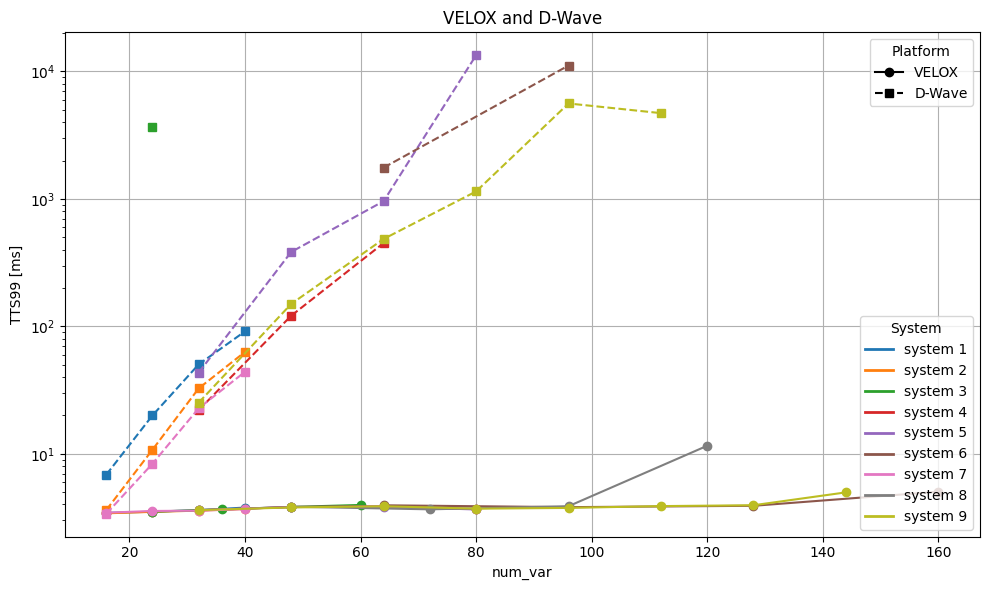

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab10.colors  # do 10 systemów
systems = [i for i in range(1,10)]
from matplotlib.lines import Line2D
for idx, system in enumerate(systems):
    df1_filtered = helpers.get_velox_success_rates(system)
    df2_filtered = helpers.get_dwave_success_rates(system=system,ta=200)

    # Dodajemy identyfikator źródła
    df1_filtered['source'] = 'VELOX'
    df2_filtered['source'] = 'DWAVE'

    # Łączymy oba DataFrame'y
    combined = pd.concat([df1_filtered,df2_filtered])
    # Reset indeksu do kolumn
    combined = combined.reset_index()
    # Tworzymy etykiety X
    combined['system'] = system
    combined['x_label'] = combined['precision'].astype(str) + '\n' + combined['timepoints'].astype(str)
    combined['tts99'] = combined.apply(lambda row: helpers.return_tts(row['success_prob'],row.runtime),axis=1)
    #print(combined[['system','num_var','precision','timepoints','source','runtime','success_prob','tts99']].to_latex(escape=True))
    df = combined.copy()
    

    velox = df[df['source'] == 'VELOX'].dropna(subset=['num_var', 'tts99'])
    dwave = df[df['source'] == 'DWAVE'].dropna(subset=['num_var', 'tts99'])
    print(f'---------- System {system} ----------')
    print(combined[['source','precision','num_var','timepoints','runtime','success_prob','tts99']])
    color = colors[idx % len(colors)]
    
    ax.plot(velox['num_var'], velox['tts99'],
            marker='o', linestyle='-', color=color, label=f'system {system}')
    
    ax.plot(dwave['num_var'], dwave['tts99'],
            marker='s', linestyle='--', color=color)

# Legenda 1: styl/metoda
style_legend = [
    Line2D([0], [0], color='black', linestyle='-', marker='o', label='VELOX'),
    Line2D([0], [0], color='black', linestyle='--', marker='s', label='D-Wave')
]

legend1 = ax.legend(handles=style_legend, title='Platform', loc='upper right')

# Legenda 2: kolory/systemy
color_legend = [
    Line2D([0], [0], color=colors[idx % len(colors)], lw=2, label=f'system {s}') for idx, s in enumerate(systems)
]

legend2 = ax.legend(handles=color_legend, title='System', loc='lower right')
ax.add_artist(legend1)  # dodaj pierwszą legendę z powrotem do osi

# Oś, tytuł itd.
ax.set_xlabel('num_var')
ax.set_ylabel('TTS99 [ms]')
ax.set_yscale('log')
ax.grid(True)
ax.set_title('VELOX and D-Wave')
plt.tight_layout()
plt.show()


---------- System 1 ----------
  source  precision  num_var  timepoints   runtime  success_prob      tts99
0  DWAVE          2     16.0           2  0.306290      0.186167   6.847180
1  DWAVE          2     24.0           3  0.297611      0.066239  19.997944
2  DWAVE          2     32.0           4  0.306519      0.027683  50.281559
3  DWAVE          2     40.0           5  0.322873      0.016167  91.226805
---------- System 2 ----------
  source  precision  num_var  timepoints   runtime  success_prob      tts99
0  DWAVE          2     16.0           2  0.295175      0.313323   3.616294
1  DWAVE          2     24.0           3  0.301268      0.121007  10.756733
2  DWAVE          2     32.0           4  0.313204      0.043273  32.605325
3  DWAVE          2     40.0           5  0.308053      0.022287  62.940057
---------- System 3 ----------
  source  precision  num_var  timepoints   runtime  success_prob       tts99
0  DWAVE          3     24.0           2  0.293452      0.000372  3635

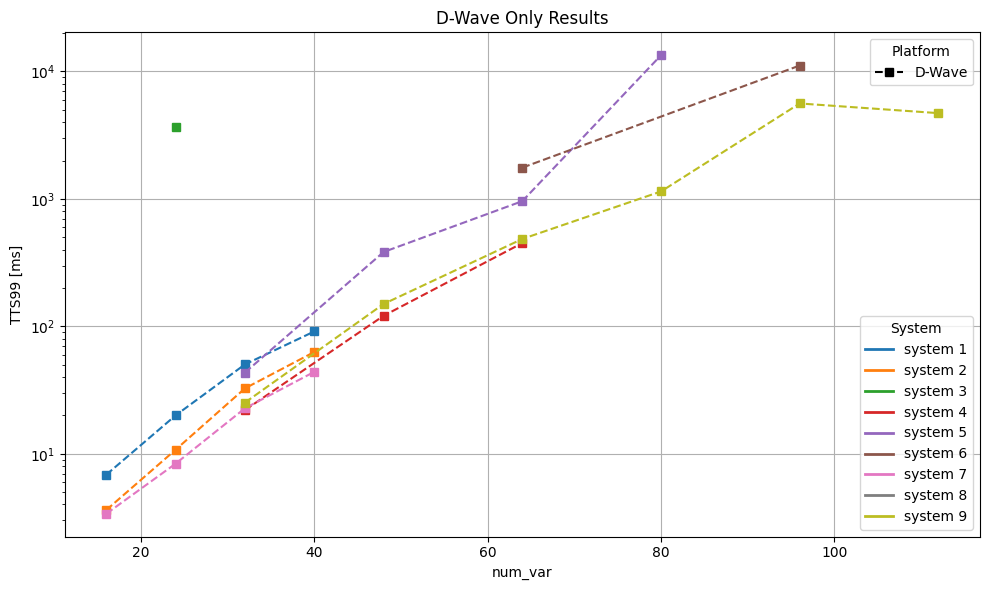

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab10.colors  # do 10 systemów
systems = [i for i in range(1,10)]
from matplotlib.lines import Line2D

for idx, system in enumerate(systems):
    # Tylko D-Wave
    df2_filtered = helpers.get_dwave_success_rates(system=system)
    df2_filtered['source'] = 'DWAVE'
    df2_filtered = df2_filtered.reset_index()
    df2_filtered['system'] = system
    df2_filtered['x_label'] = df2_filtered['precision'].astype(str) + '\n' + df2_filtered['timepoints'].astype(str)
    df2_filtered['tts99'] = df2_filtered.apply(lambda row: helpers.return_tts(row['success_prob'], row.runtime), axis=1)
    
    df = df2_filtered.dropna(subset=['num_var', 'tts99'])

    print(f'---------- System {system} ----------')
    print(df[['source', 'precision', 'num_var', 'timepoints', 'runtime', 'success_prob', 'tts99']])

    color = colors[idx % len(colors)]
    ax.plot(df['num_var'], df['tts99'],
            marker='s', linestyle='--', color=color, label=f'system {system}')

# Legenda: kolory / systemy
color_legend = [
    Line2D([0], [0], color=colors[idx % len(colors)], lw=2, label=f'system {s}') for idx, s in enumerate(systems)
]

# Styl D-Wave tylko
style_legend = [
    Line2D([0], [0], color='black', linestyle='--', marker='s', label='D-Wave')
]

legend1 = ax.legend(handles=style_legend, title='Platform', loc='upper right')
legend2 = ax.legend(handles=color_legend, title='System', loc='lower right')
ax.add_artist(legend1)

# Oś, tytuł itd.
ax.set_xlabel('num_var')
ax.set_ylabel('TTS99 [ms]')
ax.set_yscale('log')
ax.grid(True)
ax.set_title('D-Wave Only Results')
plt.tight_layout()
plt.show()


/home/atg205/Documents/__Dokumente/Uni/UPMC/stage gl/DWaveDynamics/.venv/lib/python3.11/site-packages/matplotlib/transforms.py:2436: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
/home/atg205/Documents/__Dokumente/Uni/UPMC/stage gl/DWaveDynamics/.venv/lib/python3.11/site-packages/matplotlib/transforms.py:2436: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


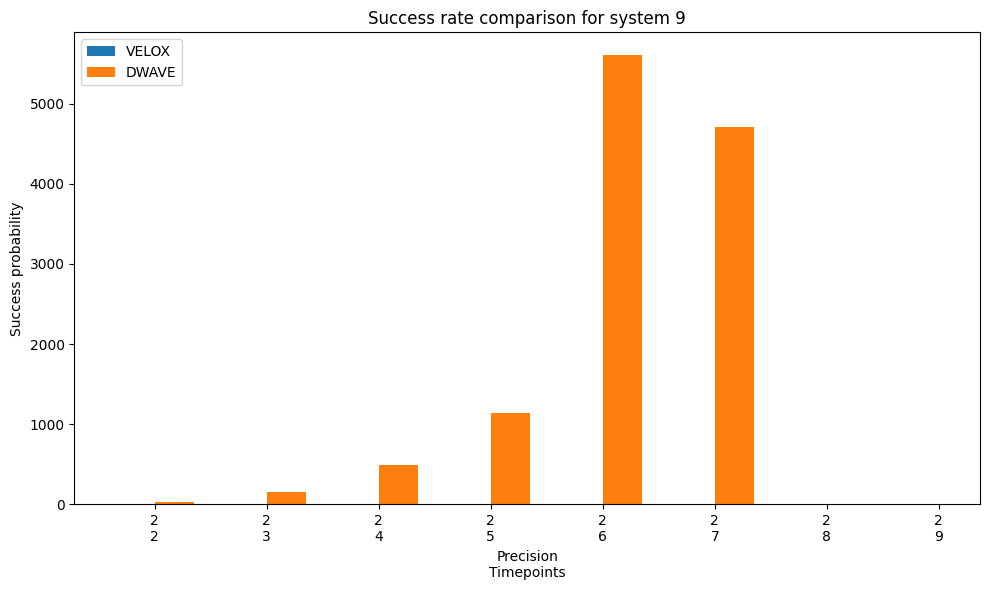

In [13]:
# Ustawienia wykresu
fig, ax = plt.subplots(figsize=(10, 6))

# Rysujemy słupki
sources = combined['source'].unique()
x_labels = combined['x_label'].unique()
x = range(len(x_labels))
bar_width = 0.35

for i, source in enumerate(sources):
    subset = combined[combined['source'] == source]
    offset = [xi + i * bar_width for xi in x]
    ax.bar(offset, subset['tts99'], width=bar_width, label=source)

# Oś X
ax.set_xticks([xi + bar_width / 2 for xi in x])
ax.set_xticklabels(x_labels)
ax.set_xlabel('Precision\nTimepoints')
ax.set_ylabel('Success probability')
ax.set_title(f'Success rate comparison for system {system}')
ax.legend()

plt.tight_layout()
plt.show()

## Success rates

In [101]:
system = 9
df_dict = {}
for ta in [10,100,200,500]:
    df = helpers.get_dwave_success_rates(system, ta=ta,grouped=True)
    df = df[df['timepoints'].isin([2, 3, 4, 5])]
    df_dict[ta] = list(df['success_prob'])
    tp_list = list(df['timepoints'])

tp_list=[f"{i} timepoints" for i in tp_list]
print(df_dict)
df_ta = pd.DataFrame.from_dict(df_dict).transpose().set_axis(tp_list,axis=1)
df_ta

{10: [0.02669090909090909, 0.006261904761904762, 0.00036734693877551024, 0.0003125], 100: [0.08766666666666667, 0.01723404255319149, 0.004633333333333334, 0.00047826086956521735], 200: [0.10961538461538461, 0.02462857142857143, 0.003777777777777778, 0.000908256880733945], 500: [0.13464197530864197, 0.042210526315789476, 0.010954545454545455, 0.005829787234042554]}


,2 timepoints,3 timepoints,4 timepoints,5 timepoints
10,0.026691,0.006262,0.000367,0.000313
100,0.087667,0.017234,0.004633,0.000478
200,0.109615,0.024629,0.003778,0.000908
500,0.134642,0.042211,0.010955,0.005830


In [52]:
df = helpers.get_dwave_success_rates(4, ta=200,grouped=False)
def calculate_percentile(group, percentile):
    return np.percentile(group, percentile)

# Calculate the 25th, 50th, and 90th percentiles
percentiles = df.groupby(['precision','timepoints','topology'])['success_prob'].agg(
    percentile_25=lambda x: calculate_percentile(x,50)-calculate_percentile(x, 25),
    percentile_50=lambda x: calculate_percentile(x, 50),  # Median
    percentile_75=lambda x: calculate_percentile(x, 75)-calculate_percentile(x,50)
)
percentiles

percentile_25  percentile_50  percentile_75
precision timepoints topology                                             
2         2          6.4               0.012          0.051          0.032
          3          6.4               0.004          0.010          0.003
          4          6.4               0.002          0.003          0.002
          5          6.4               0.000          0.000          0.000

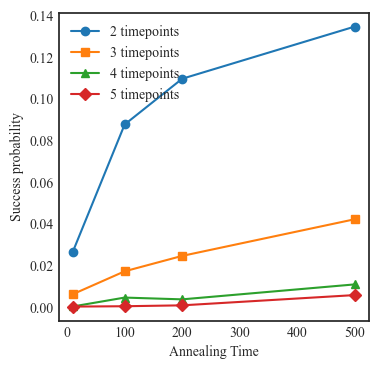

In [102]:
import matplotlib.font_manager as fm
markers = ['-o', '-s', '-^', '-D']  # 4 different markers
fm.fontManager.addfont("../times.ttf")  #path to the times.ttf file on your computer
plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ['Times New Roman'],
})

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'stix'

ax = df_ta.plot(style=markers,  figsize=(4, 4))  # plot the dataframe and set Time as x
fig =ax.get_figure()
ax.set_xlabel('Annealing Time')
ax.set_ylabel('Success probability')
ax.legend(loc='upper left')
plt.savefig(f'../plots/system_{system}_ta.pdf',bbox_inches='tight')

/tmp/ipykernel_42368/3790062929.py:3: DeprecationWarning: BinaryQuadraticModel.to_networkx_graph() is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use dimod.to_networkx_graph() instead.
  G = inst.qubo.to_networkx_graph()


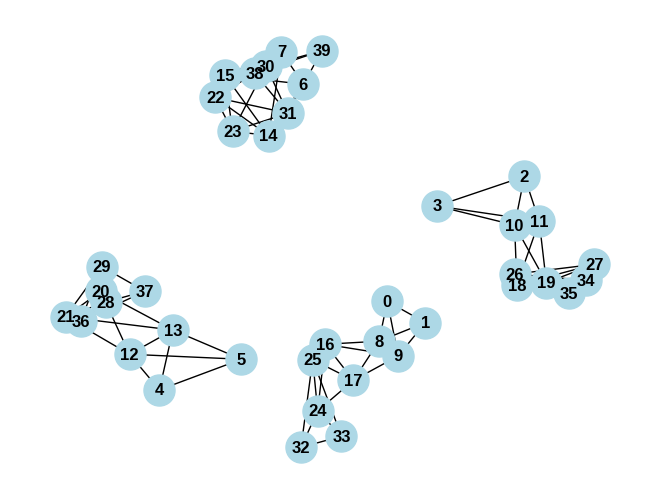

In [46]:
inst = instance.Instance(2)
inst.create_instance(2,5)
G = inst.qubo.to_networkx_graph()
nx.draw(G,nx.spring_layout(G, k=0.5), with_labels=True, node_color='lightblue', 
        node_size=500, font_size=12, font_weight='bold')

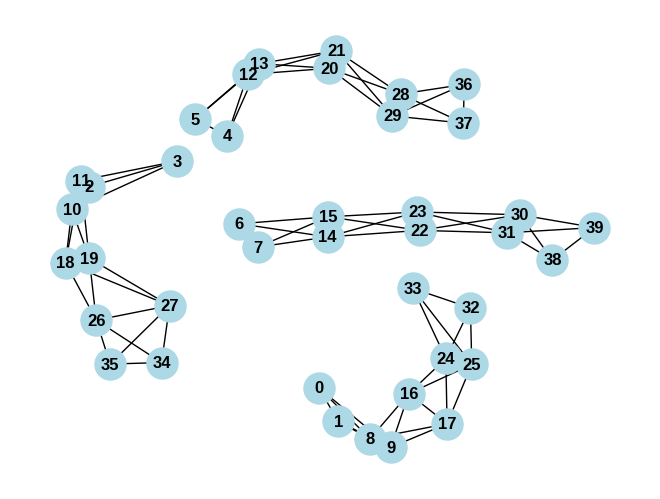

In [50]:
nx.draw(G,nx.spring_layout(G, k=0.5), with_labels=True, node_color='lightblue', 
        node_size=500, font_size=12, font_weight='bold')